# Why are delta-AUC-PR scores so different across datasets?
The output of the notebook 4.3 shows that there is vastly different performance for our pipeline depending upon which dataset is being used. Prism results in delta-AUC-PR scores that are marginally better than chance. However, the delta-AUC-PR scores are significantly better for toxvaldb (0.2-0.3). What is the reason for this vastly different performance aross support set sizes?

I will start by exploring some of the following questions:
- Are there some types of assays (e.g. aquatic predictions) for which toxvaldb has significantly better classification performance?
- Do different median active ratios across the datasets explain this difference?

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import duckdb

In [ ]:
def get_run_info(filepath):

    # Split the string at each slash to isolate each part of the path
    parts = filepath.split("/")

    # The target part is the one that contains 'params.dataset' and 'params.support_set_size'
    target = [part for part in parts if "params.dataset" in part and "params.support_set_size" in part][0]

    # Split the target part at each comma
    params = target.split(",")

    # Split each parameter at the equals sign and take the second part
    dataset = params[0].split("=")[1]
    support_set_size = int(params[1].split("=")[1])  # convert 
    to int for numerical operations

    return {"dataset": dataset, "support_set_size": support_set_size}


def rename_filename_to_assay_id(filename):
    # Get basename without file extension from filename
    base_name = os.path.basename(filename)
    name_without_extension = os.path.splitext(base_name)[0]
    return name_without_extension

## Assay makeup

I'll start by loading in the evaluation data for each dataset.

In [3]:
RUN_DIR = "/Users/sethhowes/Desktop/FS-Tox/multirun/2023-07-20/15-53-19"
run_dirs = [f"{RUN_DIR}/{config}" for config in os.listdir(RUN_DIR) if config != "multirun.yaml"]
run_dirs = [f"{run_dir}/data/processed/score/*.parquet" for run_dir in run_dirs]

support_sizes = [8, 16, 32, 64]
datasets = ["toxcast", "toxval", "nci60", "cancerrx", "prism"]

con = duckdb.connect()

dfs = []

for run_dir in run_dirs:
    info = get_run_info(run_dir)
    query = f"""
    SELECT delta_auc_pr, filename AS assay_id
    FROM read_parquet('{run_dir}', filename=true)
    """
    try:
        df = con.execute(query).df()
        df["support_set_size"] = info["support_set_size"]
        df["dataset"] = info["dataset"]
        dfs.append(df)
    except Exception as e:
        print(f"No data for {info['dataset']} with support set size of {info['support_set_size']}")


# Concatenate all dataframes into one
df = pd.concat(dfs, ignore_index=True)

# Change assay id column so that filename is converted to assay id
df["assay_id"] = df["assay_id"].apply(rename_filename_to_assay_id)

In [4]:
df.head()

,delta_auc_pr,assay_id,support_set_size,dataset
0,0.214189,dc81033bf0ce9cb,32,toxcast
1,0.078312,9d741d12f26e3a2,32,toxcast
2,0.207396,2da3a1f2bb38e61,32,toxcast
3,0.072056,663edce479311b3,32,toxcast
4,0.114713,0660b7e9e225700,32,toxcast


## Assay breakdown
I will now see what the different components are for the toxvaldb assays. I want to see whether there are certain assay components (e.g. oral vs. aqueous delivery) that results in different predictive performance.

In [5]:
toxval = df[df["dataset"] == "toxval"]
toxval_32 = df[df["support_set_size"] == 32]

In [6]:
toxval_components = pd.read_parquet(f"{RUN_DIR}/params.dataset=toxval,params.support_set_size=32/data/processed/assay_id/toxval.parquet")

In [7]:
pd.set_option('display.max_colwidth', None)

toxval_merged = toxval.merge(toxval_components, on="assay_id")
toxval_merged.sort_values(by="delta_auc_pr", ascending=False)

,delta_auc_pr,assay_id,support_set_size,dataset,assay_name
6,0.310458,3750021a43179d9,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_EC50_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
0,0.289894,9e409008c12c454,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_LC50_Sheepshead Minnow_aqueous_mg/m3_mortality_ECOTOX"
21,0.289754,fbf18f4352e1c05,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Bluegill_aqueous_mg/m3_mortality_ECOTOX"
9,0.281419,83f8eb37368cb38,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
18,0.265265,0384960b45bc7c3,64,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Rainbow Trout_aqueous_mg/m3_mortality_ECOTOX"
2,0.247231,9e409008c12c454,32,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_LC50_Sheepshead Minnow_aqueous_mg/m3_mortality_ECOTOX"
10,0.244229,83f8eb37368cb38,16,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
11,0.230764,83f8eb37368cb38,32,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Water Flea_aqueous_mg/m3_neurotoxicity_ECOTOX"
20,0.207688,0384960b45bc7c3,32,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Rainbow Trout_aqueous_mg/m3_mortality_ECOTOX"
19,0.207216,0384960b45bc7c3,16,toxval,"Environmental Fate and Effects Division, U.S.EPA, Washington, D.C.: U.S. Environmental Protection Agency Pesticide Ecotoxicity Database (Formerly: Environmental Effects Database (EEDB)) 1992_NOEL_Rainbow Trout_aqueous_mg/m3_mortality_ECOTOX"


There doesn't appear to be an obvious pattern as to whether certain assay components improve performance.

## Active ratio - toxval
Maybe there is a correlation between predictive performance and the active ratio of a given assay. I will use the run where a support set size of 32 is used so that I can appear a given set of assays without the assays being repeated.

In [8]:
run_dir = f"{RUN_DIR}/params.dataset=toxval,params.support_set_size=32/data/processed/assay/*parquet"

query = f"""
    SELECT ground_truth, filename AS assay_id
    FROM read_parquet('{run_dir}', filename=true)
    """
df = con.execute(query).df()

# Change assay id column so that filename is converted to assay id
df["assay_id"] = df["assay_id"].apply(rename_filename_to_assay_id)

In [9]:
proportion = df.groupby("assay_id")["ground_truth"].sum() / df.groupby("assay_id")["ground_truth"].count()

In [10]:
df = df.merge(proportion, on="assay_id")
df.rename(columns={"ground_truth_x": "ground_truth", "ground_truth_y": "active_ratio"}, inplace=True)

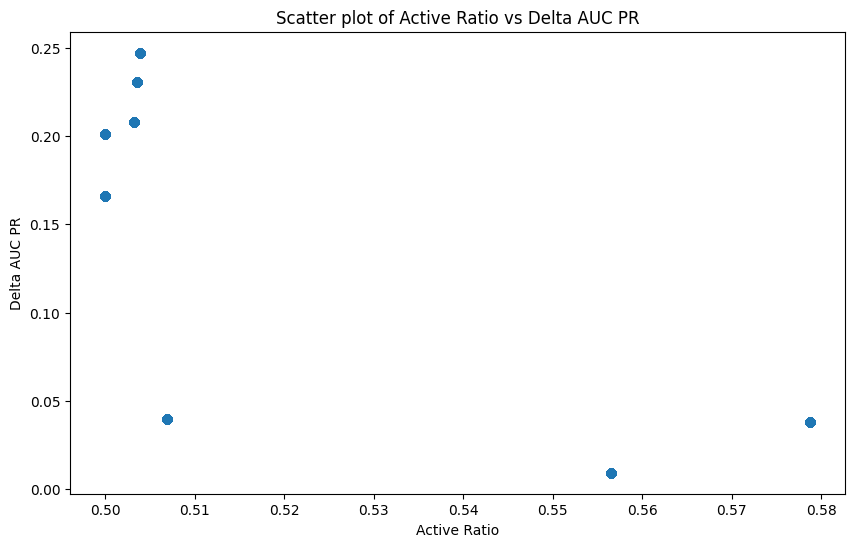

In [11]:
merged = toxval_32.merge(df, on="assay_id")

# Create scatter plot of merged["active_ratio"] vs merged["delta_auc_pr"]
plt.figure(figsize=(10, 6))
plt.scatter(merged["active_ratio"], merged["delta_auc_pr"])
plt.xlabel('Active Ratio')
plt.ylabel('Delta AUC PR')
plt.title('Scatter plot of Active Ratio vs Delta AUC PR')
plt.show()

It appears that those datapoints with an active ratio closer to 0.5 have larger delta-AUC-PR scores.

I also want to plot the absolute active ratio difference from 0.5 vs delta-AUC-PR.

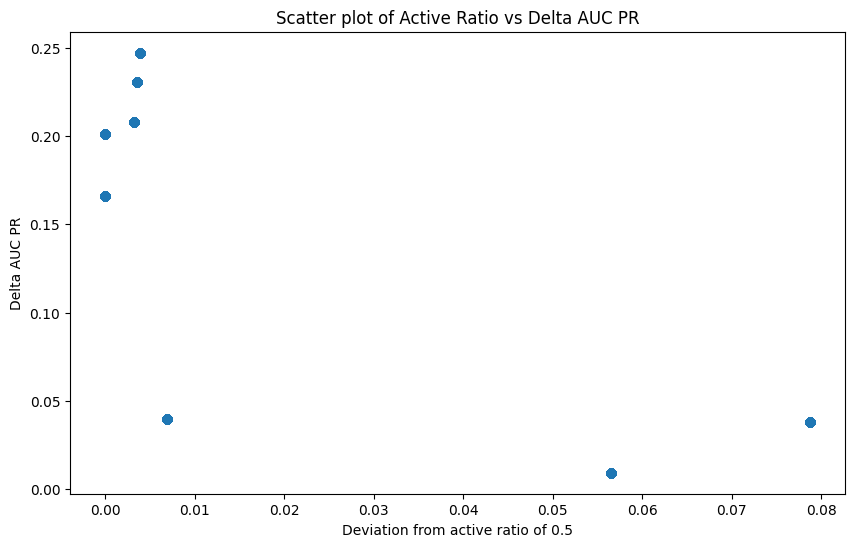

In [12]:
diff = abs(merged["active_ratio"] - 0.5)

# Create scatter plot of merged["active_ratio"] vs merged["delta_auc_pr"]
plt.figure(figsize=(10, 6))
plt.scatter(diff, merged["delta_auc_pr"])
plt.xlabel('Deviation from active ratio of 0.5')
plt.ylabel('Delta AUC PR')
plt.title('Scatter plot of Active Ratio vs Delta AUC PR')
plt.show()

This shows a negative correlation between active ratio deviation from 0.5 and preditive performance.

In [14]:
diff.corr(merged["delta_auc_pr"])

-0.7793200569045445

There is a very strong negative correlation.

In [23]:
diff.median()

0.12075029308323565

The average deviation from 0.5 active ratio is 0.12

## Active ratio - toxcast
I want to check and see if this is the case for the toxcast dataset as well.

In [15]:
run_dir = f"{RUN_DIR}/params.dataset=toxcast,params.support_set_size=32/data/processed/assay/*parquet"

query = f"""
    SELECT ground_truth, filename AS assay_id
    FROM read_parquet('{run_dir}', filename=true)
    """
df = con.execute(query).df()

# Change assay id column so that filename is converted to assay id
df["assay_id"] = df["assay_id"].apply(rename_filename_to_assay_id)

In [16]:
proportion = df.groupby("assay_id")["ground_truth"].sum() / df.groupby("assay_id")["ground_truth"].count()

In [17]:
df = df.merge(proportion, on="assay_id")
df.rename(columns={"ground_truth_x": "ground_truth", "ground_truth_y": "active_ratio"}, inplace=True)

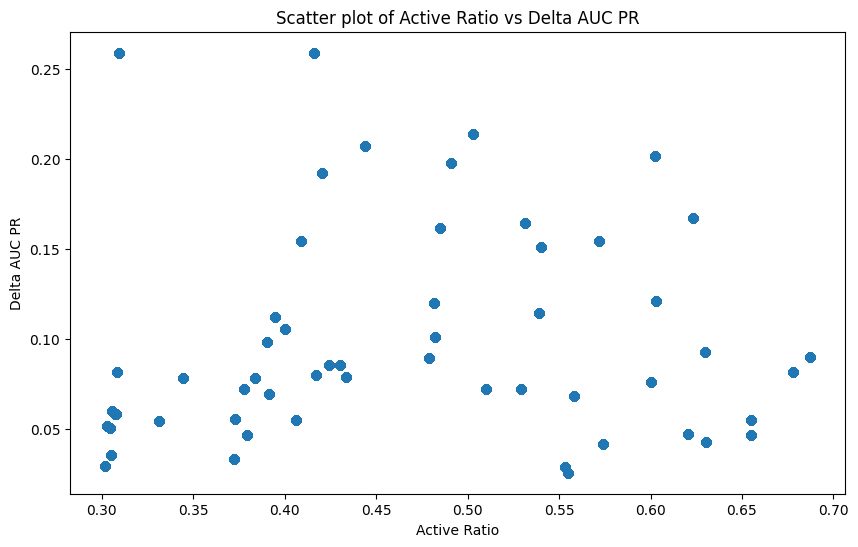

In [18]:
merged = toxval_32.merge(df, on="assay_id")

# Create scatter plot of merged["active_ratio"] vs merged["delta_auc_pr"]
plt.figure(figsize=(10, 6))
plt.scatter(merged["active_ratio"], merged["delta_auc_pr"])
plt.xlabel('Active Ratio')
plt.ylabel('Delta AUC PR')
plt.title('Scatter plot of Active Ratio vs Delta AUC PR')
plt.show()

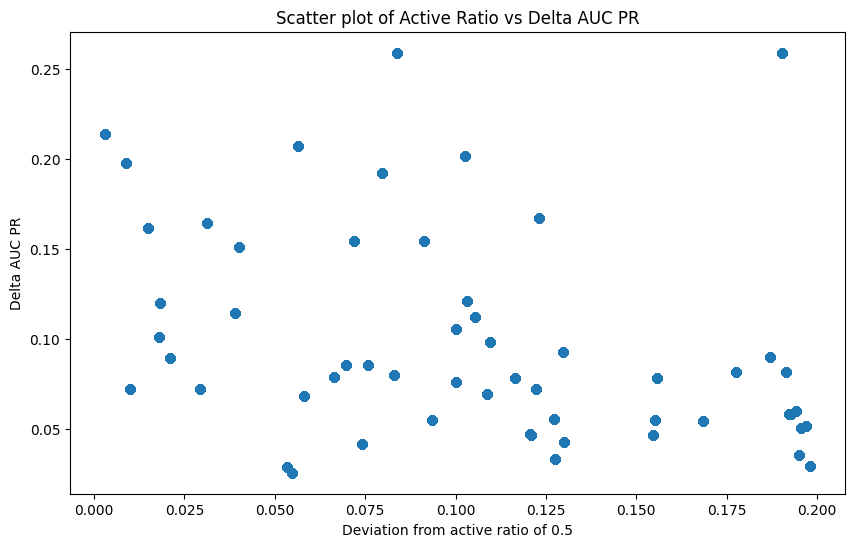

In [19]:
diff = abs(merged["active_ratio"] - 0.5)

# Create scatter plot of merged["active_ratio"] vs merged["delta_auc_pr"]
plt.figure(figsize=(10, 6))
plt.scatter(diff, merged["delta_auc_pr"])
plt.xlabel('Deviation from active ratio of 0.5')
plt.ylabel('Delta AUC PR')
plt.title('Scatter plot of Active Ratio vs Delta AUC PR')
plt.show()

In [20]:
diff.median()

0.12075029308323565

In [21]:
diff.corr(merged["delta_auc_pr"])

-0.4581615358607872

So it seems there is a strong negative correlation between active ratio deviation from 0.5 and delta-auc-pr.

It may be that there are different active ratios across different datasets, which is what explain the difference in predictive performance.

I will calculate the median delta-AUC-PR scores only for those values with an absolute deivation of less than or equal to 0.05 for the toxcast dataset. I would expect the median delta-AUC-PR value to be similar to toxvaldb (around 0.2) 
if this imbalance is indeed repsonsible for the difference between the two datasets.

In [24]:
merged[diff <= 0.1]["delta_auc_pr"].median()

0.10143497271853208

The median value is much lower than expected, meaning that this imbalance is not responsible for the difference in predictive performance between the two assays.